In [1]:
from fractal_printer import fractal_sdfs as fs
import numpy as np
from importlib import reload
import quaternion
from sdf import sdf
import matplotlib.pyplot as plt

In [2]:
# Make the inital, coarse mesh

reload(fs)
julia_sdf = fs.quaternion_julia_sdf(c = quaternion.quaternion(0.4,0.2,0.5,0), iterations=60, offset=0.005)

radius = 1.2
points = julia_sdf.generate(bounds = ((-radius,)*3,(radius,)*3),samples=2**22)

sdf.stl.write_binary_stl("raw_julia.stl",points)

min -1.2, -1.2, -1.2
max 1.2, 1.2, 1.2
step 0.0148819, 0.0148819, 0.0148819
4657463 samples in 216 batches with 8 workers
  100% (216 of 216) [##############################] 0:00:05 0:00:00    
107 skipped, 16 empty, 93 nonempty
1022076 triangles in 4.74647 seconds


(1920, 3)


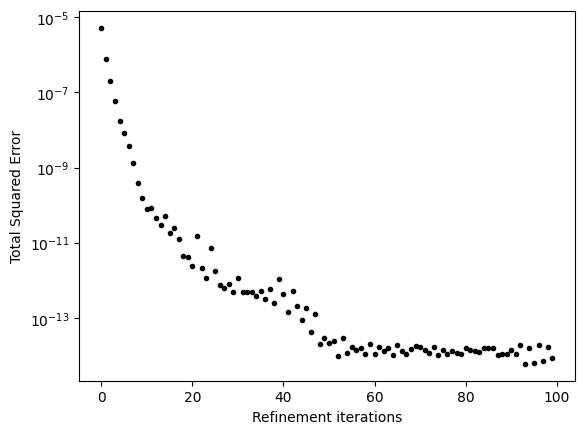

In [ ]:
refined_points = np.array(points).copy()
print(refined_points.shape)

def gradient(r, f, epsilon=1e-3):
    gx = (f(r + np.array([epsilon,0,0])) - f(r - np.array([epsilon,0,0]))) / (2*epsilon)
    gy = (f(r + np.array([0,epsilon,0])) - f(r - np.array([0,epsilon,0]))) / (2*epsilon)
    gz = (f(r + np.array([0,0,epsilon])) - f(r - np.array([0,0,epsilon]))) / (2*epsilon)
    return np.hstack((gx, gy, gz))

def refine_points(points, distance_function, steps = 1, epsilon=1e-8):
    new_points = points.copy()
    for _ in range(steps):
        f = distance_function(new_points)
        grad = gradient(new_points, distance_function, epsilon=epsilon)

        new_points = new_points - f * grad / np.sum(grad*grad,axis=-1)[:,np.newaxis] * 0.5

    return new_points

def error(points, distance_function):
    f = distance_function(points)
    return np.sum(f*f)

fig, ax = plt.subplots(1,1)
ax.set_yscale("log")
ax.set_ylabel("Total Squared Error")
ax.set_xlabel("Refinement iterations")
for i in range(25):
    ax.plot(i, error(refined_points, julia_sdf),"k.")
    refined_points = refine_points(refined_points, julia_sdf, epsilon=1e-8)

sdf.stl.write_binary_stl("refined_julia.stl",points)